# April 19, 2019

In this notebook, we implement **meaning to utterance** and **utterance to meaning** encoders using an RNN that has attention, perfect memory, and allow for batch training over utterances that are **fixed** or **variable**.

In [0]:

#torch imports
import torch
if torch.cuda.is_available(): import torch.cuda as t
else: import torch as t
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#other imports
import numpy as np
import matplotlib.pyplot as plt
import math, random
from collections import namedtuple

##Utils

In [0]:
def one_hot(idx, length):
    '''
    use example: one_hot(torch.LongTensor(5,1).random_() % 10, 10)

    :param idx: 
    some LongTensor of size [-1,-1,...,1]
    :param length:
    one_hot length
    '''

    assert(idx.size()[-1] == 1)
    onehot = t.FloatTensor(*(list(idx.size()[:-1]) + [length]))
    onehot.zero_()
    onehot.scatter_(len(idx.size())-1, idx, 1)

    return onehot



## Models


---


**Meaning Encoder**
We call the meaning encoder the "speaker". At the high-level, the speaker is a function that maps meaning to an utterance (a sequence of symbols):
$$S: M \rightarrow U$$

For this particular implementation, we use an LSTM and an attention layer to generate a latent represenation $h_t$ of $\underline{u}_t|m$ at some timestep $t$, which is then decoded by a softmax FF network into $A$. We then sample $a \sim A$ which is the next symbol in the generated utterance $\underline{u}$. We give the model the capacity for "perfect memory" by providing the LSTM and the $h$-decoder a preserved observation of **\[1\]** $m$ and **\[2\]** every $h_t$ wherever possible. Our method to do this is:

> **\[1\]** $m^{\mathbb{1}}$ (the ${\mathbb{1}}$ superscript denotes a 1-hot) is concatenated to each element $a_t^{\mathbb{1}}$ in $\underline{u}_t$ for the LSTM, to each $h_t$ for the attention layer, and to the weighted $h$ that is decoded into $A$. \\
> **\[2\]** The input $h$ to the softmax FF decoder is a sum of weighted vectors $h_t$, that is $h = \sum_t c_t h_t$ where $c_t$ is determined by an attention layer which is another softmax FF. We write each $h_t$ to an external array in the code.

Psuedocode:
```
@ t = 0:  
    1. an initial (h_0+meaning) (skipping RNN and attention) is passed into decoder layer giving a_distro
    2. an (in-progress) utterance begins here with either a ~ a_distro, or a target a is given
    
@ t > 0:
    1. h_0 and (utterance+meaning) is passed into RNN, producing hs (h_1:h_t)
    2. (hs+meaning) is passed into attention layer, producing attn_energies
    3. weighted combination of hs with attn_energies, giving weighted_rep
    4. (weighted_rep+meaning) is passed into the decoder layer, giving a_distro
    5. the in-progress utterance is added onto with new symbol (either sampled from a_distro, or given by a target utterance)
(continued until T = MAX_U_LEN or a = EOS)

```


A batch-processing implementation for variable length utterances: \\
Focus on this after you write the simpler implementation, because it must have the same batch-processing structures.

### Speaker

In [0]:
class Speaker(nn.Module):
    '''
    Speaker: Generative RNN with an attention layer and a decoder layer.
    '''
    
    def __init__(self, meaning_size, action_size, max_u_len, **hyperparameters):
        '''
        meaning_size, action_size, max_u_len, {"hidden_size":256, "n_layers":1, "dropout":0.1, "bidirectional":True}
        :param meaning_size: N_MEANINGS
        :param action_size: N_ACTIONS
        :param hidden_size: hidden size of the latent representation for RNN

        :param hyperparameters: {"n_layers":int, "dropout":float, "bidirectional":bool}
        '''
        super(Speaker, self).__init__()
        self.m_size = meaning_size
        self.a_size = action_size
        self.max_u_len = max_u_len
        
        self.hidden_size = hyperparameters["hidden_size"]
        self.n_layers = hyperparameters["n_layers"]
        self.dropout = hyperparameters["dropout"]
        self.bidirectional = hyperparameters["bidirectional"]
        self.max_ent = hyperparameters["max_ent"]
        
        #initial h_0
        if(self.bidirectional):
            self.h_0 = nn.Parameter(t.FloatTensor(2*self.n_layers, self.hidden_size).uniform_(0,1))
        else:
            self.h_0 = nn.Parameter(t.FloatTensor(self.n_layers, self.hidden_size).uniform_(0,1))
        stdv = 1. / math.sqrt(self.h_0.size(1))
        self.h_0.data.normal_(mean=0, std=stdv)
            
        #RNN
        self.rnn = nn.LSTM(input_size = self.a_size + self.m_size, hidden_size = self.hidden_size, num_layers = self.n_layers, batch_first = False, dropout = self.dropout, bidirectional = self.bidirectional)
        
        #Attention Layer: (hs+meaning) [T,B,|H| + |M|] ==> attn_energies [T,B,1] softmax'd over time (dim = 0)
#         self.softmaxFF_attention = nn.Sequential(nn.Linear(in_features = self.hidden_size + self.m_size, out_features = 1),
#                                                  nn.Softmax(dim = 0))
        self.softmaxFF_attention = nn.Sequential(nn.Linear(in_features = self.hidden_size + self.m_size, out_features = 1),
                                                 nn.ReLU(),
                                              nn.Linear(in_features = self.hidden_size, out_features = 1),
                                              nn.Softmax(dim = 0))
        #Decoder Layer:
#         self.softmaxFF_action = nn.Sequential(nn.Linear(in_features = self.hidden_size + self.m_size, out_features = self.a_size), 
#                                                   nn.Softmax(dim = 1))
        self.softmaxFF_action = nn.Sequential(nn.Linear(in_features = self.hidden_size + self.m_size, out_features = self.hidden_size), 
                                              nn.ReLU(),
                                              nn.Linear(in_features = self.hidden_size, out_features = self.a_size),
                                              nn.Softmax(dim = 1))
        
        #h_(0:t)
        self.hs = None
        #h_(t)
        self.h_t = None

    def forward(self, meanings_1h, utterance_feats, return_all = False):
        '''
        :meanings_1h: [B,|M|]
        :utterance_feats: [T,B,|A|]:
        
        :return:
        '''
        batch_size = meanings_1h.size(0)
        time_size = utterance_feats.size(0)
        
        #calling Speaker(m) at the beginning without any utterance: pass h_0 + meaning into decoder
        if(len(utterance_feats) == 0):
            h_0 = torch.mean(self.h_0, dim = 0).expand(batch_size, -1) #[N_D*N_L, |H|] => [B,|H|]
            decoder_layer_input = torch.cat([h_0, meanings_1h], dim = 1) #[B,|H|] + [B,|M|] => [B,|H|+|M|]
            a_distro = self.softmaxFF_action(decoder_layer_input) #[B,|H|+|M|] => [B,|A|]
            return a_distro
        
        
        #adding a meaning signal to the utterance at every symbol
        t_stacked_meanings_1h = meanings_1h.unsqueeze(0).expand(time_size,-1,-1) #[B,|M|] => [1,B,|M|] => [T,B,|M|]
        rnn_input = torch.cat([utterance_feats,t_stacked_meanings_1h], dim = 2) #[T,B,|A|] + [T,B,|M|] => [T,B,|A|+|M|]
        
        #rnn forward and process outputs
        h_0 = self.h_0.unsqueeze(1).repeat(1, batch_size, 1) #[N_D*N_L, |H|] => [N_D*N_L,B,|H|]
        self.hs, (self.h_t, _) = self.rnn(rnn_input, (h_0,h_0))
        
        #sum reps over directions(hs) and layers(h_t)
        if(self.bidirectional):
            self.hs = self.hs[:,:,:self.hidden_size] + self.hs[:,:,self.hidden_size:] #[T,B,2*|H|] ==> [T,B,|H|]
        self.h_t = torch.sum(self.h_t, dim = 0) #[N_L,B,|H|] ==> [B,|H|]
        
        if(return_all):
            a_distros = t.FloatTensor(time_size, batch_size, self.a_size)
            for tstep in range(time_size):
                #attention layer: add meaning signal to each h
                hs_w_meaning = torch.cat([self.hs[:tstep+1], t_stacked_meanings_1h[:tstep+1]], dim = 2) #[T,B,|H| + |M|]
                attn_energies = self.softmaxFF_attention(hs_w_meaning) #[T,B,1]
                weighted_rep = torch.bmm(self.hs[:tstep+1].permute(1,2,0), attn_energies.permute(1,0,2)).squeeze(2) #[B,|H|]
                decoder_layer_input = torch.cat([weighted_rep, meanings_1h], dim = 1) #[B,|H|+|M|]
                a_distros[tstep] = self.softmaxFF_action(decoder_layer_input) #[B,|H|+|M|] => [B,|A|]
            return a_distros #[T,B,|A|]
        else:
            #attention layer: add meaning signal to each h
            hs_w_meaning = torch.cat([self.hs, t_stacked_meanings_1h], dim = 2) #[T,B,|H| + |M|]
            attn_energies = self.softmaxFF_attention(hs_w_meaning) #[T,B,1]

            #decoder layer: get weighted_rep by bmm, then add meaning signal, and finally pass into decoder layer
            #     to get weighted_rep by torch.bmm([BxNxM] x [BxMxP] = [BxNxP]) 
            #     first permute ([T,B,|H|] ==> [B,|H|,T]) and ([T,B,1] ==> [B,T,1])
            #     then bmm(hs, attn_energies):  [B,|H|,T]x[B,T,1] = [B,|H|,1] ==> [B,|H|]
            weighted_rep = torch.bmm(self.hs.permute(1,2,0), attn_energies.permute(1,0,2)).squeeze(2) #[B,|H|]
            decoder_layer_input = torch.cat([weighted_rep, meanings_1h], dim = 1) #[B,|H|+|M|]
            a_distro = self.softmaxFF_action(decoder_layer_input) #[B,|H|+|M|] => [B,|A|]

            return a_distro
    
    def sample_utterance(self, meanings_1h):
        batch_size = meanings_1h.size(0)
        utterance = t.LongTensor(self.max_u_len, batch_size)
        
        #regularizing ent term
        a_distro_ent = t.FloatTensor(self.max_u_len)
        
        for tstep in range(self.max_u_len):
            utterance_feats = one_hot(utterance[:tstep].unsqueeze(-1), self.a_size)    
            a_distro = self(meanings_1h, utterance_feats)
            sampled_a = torch.distributions.Categorical(a_distro).sample()
            utterance[tstep,:] = sampled_a
            
            a_distro_ent[tstep] = -(a_distro * torch.log(a_distro)).mean()
            
        utterance = utterance.transpose(1,0) #[B,T]
        
        return utterance, a_distro_ent.mean()
    
    def gumbel_sample_utterance(self, meanings_1h, gumbel_sample = False):
        batch_size = meanings_1h.size(0)
        utterance_feats = t.FloatTensor(self.max_u_len, batch_size, self.a_size)
        
        #regularizing ent term
        a_distro_ent = t.FloatTensor(self.max_u_len)
        
        for tstep in range(self.max_u_len):
            a_distro = self(meanings_1h, utterance_feats[:tstep])
            utterance_feats[tstep] = F.gumbel_softmax(a_distro, tau = GUMBEL_TAU, hard = True)
            
            a_distro_ent[tstep] = -(a_distro * torch.log(a_distro)).mean()
        
        return utterance_feats, a_distro_ent.mean()
    
    def ideal_listener_loss(self, meanings_1h, beta = 3):
        batch_size = meanings_1h.size(0)
        utterance = t.LongTensor(self.max_u_len, batch_size)
        #regularizing ent term
        a_distro_ent = t.FloatTensor(self.max_u_len)
        log_p_u_given_m = t.FloatTensor(batch_size).fill_(0)
        
        for tstep in range(self.max_u_len):
            utterance_feats = one_hot(utterance[:tstep].unsqueeze(-1), self.a_size)    
            a_distro = self(meanings_1h, utterance_feats)
            sampled_a = torch.distributions.Categorical(a_distro).sample()
            utterance[tstep,:] = sampled_a
            log_p_u_given_m += -torch.log(a_distro[range(batch_size),sampled_a])
            
            a_distro_ent[tstep] = -(a_distro * torch.log(a_distro)).mean()
            
        utterance_feats = one_hot(utterance.unsqueeze(-1), self.a_size) #[T,B,A]
        
        cond_ent = log_p_u_given_m.mean() #H[U|M]
        
        #calculating H[U] assuming B = |M|
        ent = t.FloatTensor(batch_size).fill_(0.) #H[U]
        for b in range(batch_size):
            #stack one u B times, to run the same utterance per meaning
            u = utterance_feats[:,b,:].view(1, self.max_u_len,self.a_size)
            one_utterance_stacked = u.expand([batch_size, self.max_u_len,self.a_size]).transpose(1,0)

            a_distros = self(meanings_1h, one_utterance_stacked, return_all = True).view(self.max_u_len * batch_size, -1) #[T*M,|A|]

            utterance_tgt_idx = torch.argmax(utterance_feats, dim = 2).view(self.max_u_len * batch_size) #[T,M,|A|] ==> [T*M]
            p_a = a_distros[range(self.max_u_len * batch_size),utterance_tgt_idx] #[T*M]
            p_a = p_a.view(self.max_u_len, batch_size).transpose(1,0) #[M,T]
            logp_a = torch.log(p_a).sum(dim = 1)
            ent[b] = -torch.sum(logp_a.exp() * logp_a)
        ent = ent.mean() #H[U]
        
        MI = ent - cond_ent
        loss = -MI - self.max_ent*a_distro_ent.mean()
        
        return utterance, loss 
    
    def nll_sample(self, meanings_1h):
        '''
        samples utterance and computes avg NLL of P(a_t|m) over t (utterance)
        :returns: 
            [BATCH] nll := the avg negative-log-likelihood of P(a_t|m) over the utterance
            utterance_feats := [T,B,|A|]
        '''
        batch_size = meanings_1h.size(0)
        utterance = t.LongTensor(self.max_u_len, batch_size) #[T,B]
        nll_time_batch = t.FloatTensor(self.max_u_len, batch_size).fill_(0.)# [T,B]
        
        #regularizing ent term
        a_distro_ent = t.FloatTensor(self.max_u_len)
        
        for tstep in range(self.max_u_len):
            utterance_feats = one_hot(utterance[:tstep].unsqueeze(-1), self.a_size) #[T,B,|A|]
            a_distro = self(meanings_1h, utterance_feats) #[B,|A|]
            sampled_a = torch.distributions.Categorical(a_distro).sample() #[B]
            utterance[tstep,:] = sampled_a #building utterance from sampling
            
            nll_time_batch[tstep,:] = -torch.log(a_distro[range(batch_size), sampled_a]) #nll[t] = nll(P(A_t)) [B]
            
            a_distro_ent[tstep] = -(a_distro * torch.log(a_distro)).mean()
            
        nll = nll_time_batch.mean(dim = 0) #[B] averaged over time
        utterance_feats = one_hot(utterance.unsqueeze(-1), self.a_size)
        return nll, utterance_feats, a_distro_ent.mean()

### Listener

In [0]:
class Listener(nn.Module):
    '''
    Listener: 
    same as listener, except it recieves the entire utterance all at once and there are no added meaning signals.
    utterance => [RNN] => hs => [ATTN] => c * hs => [DECODER] => g_distro
    '''
    
    def __init__(self, meaning_size, action_size, max_u_len, **hyperparameters):
        '''
        meaning_size, action_size, max_u_len, {"hidden_size":256, "n_layers":1, "dropout":0.1, "bidirectional":True}
        :param meaning_size: N_MEANINGS
        :param action_size: N_ACTIONS
        :param hidden_size: hidden size of the latent representation for RNN

        :param hyperparameters: {"n_layers":int, "dropout":float, "bidirectional":bool}
        '''
        super(Listener, self).__init__()
        self.m_size = meaning_size
        self.a_size = action_size
        self.max_u_len = max_u_len
        
        self.hidden_size = hyperparameters["hidden_size"]
        self.n_layers = hyperparameters["n_layers"]
        self.dropout = hyperparameters["dropout"]
        self.bidirectional = hyperparameters["bidirectional"]

        #initial h_0
        if(self.bidirectional):
            self.h_0 = nn.Parameter(t.FloatTensor(2*self.n_layers, self.hidden_size).uniform_(0,1))
        else:
            self.h_0 = nn.Parameter(t.FloatTensor(self.n_layers, self.hidden_size).uniform_(0,1))
        stdv = 1. / math.sqrt(self.h_0.size(1))
        self.h_0.data.normal_(mean=0, std=stdv)
            
        
        self.rnn = nn.LSTM(input_size = self.a_size, hidden_size = self.hidden_size, num_layers = self.n_layers, batch_first = False, dropout = self.dropout, bidirectional = self.bidirectional)
#         self.softmaxFF_attention = nn.Sequential(nn.Linear(in_features = self.hidden_size, out_features = 1), 
#                                                   nn.Softmax(dim = 0)) 
#         self.softmaxFF_decoder = nn.Sequential(nn.Linear(in_features = self.hidden_size, out_features = self.m_size), 
#                                                   nn.Softmax(dim = 1))
        self.softmaxFF_attention = nn.Sequential(nn.Linear(in_features = self.hidden_size, out_features = self.hidden_size),
                                                 nn.ReLU(),
                                                 nn.Linear(in_features = self.hidden_size, out_features = 1),
                                                 nn.Softmax(dim = 0))
        self.softmaxFF_decoder = nn.Sequential(nn.Linear(in_features = self.hidden_size, out_features = self.hidden_size), 
                                               nn.ReLU(),
                                               nn.Linear(in_features = self.hidden_size, out_features = self.m_size),
                                               nn.Softmax(dim = 1))
        
        
        self.hs = None
        #self.last_h_rep = None

    def forward(self, utterance_feats):
        '''
        :utterance_feats: [T,B,|A|]:
        '''
        batch_size = utterance_feats.size(1)
        #rnn forward and process outputs
        h_0 = self.h_0.unsqueeze(1).repeat(1, batch_size, 1) #[N_D*N_L, |H|] => [N_D*N_L,B,|H|]
        self.hs, _ = self.rnn(utterance_feats, (h_0,h_0))
        
        #sum hs over directions
        if(self.bidirectional):
            self.hs = self.hs[:,:,:self.hidden_size] + self.hs[:,:,self.hidden_size:] #[T,B,2*|H|] ==> [T,B,|H|]
        
        #attention layer
        attn_energies = self.softmaxFF_attention(self.hs) #[T,B,1]
        
        #decoder layer
        #torch.bmm([BxNxM] x [BxMxP] = [BxNxP]) so permute [T,B,|H|] and [T,B,1] => [B,|H|,T] and [B,T,1], then bmm ==> [B,|H|,1]
        weighted_rep = torch.bmm(self.h_reps.permute(1,2,0), attn_energies.permute(1,0,2)).squeeze(2) #[B,|H|]
        g_distro = self.softmaxFF_decoder(weighted_rep) #[B,|M|]
        
        return g_distro
    
    def sample_meaning(self, utterance_feats):
        '''
        :param utterance_feats:
        shape [T,B,|A|]
        '''
        g_distro = self(utterance_feats)
        sampled_g = torch.distributions.Categorical(g_distro).sample()
        return sampled_g
    
    def nll_sample(self, utterance_feats):
        '''
        negative log-likelihood of sampled meaning from listener (given u)
        
        :param utterance_feats:
            shape [T,B,|A|]
        :returns:
            loss := [BATCH] -log(p(m|u)) 
            sampled_g := [BATCH] m
        '''
        batch_size = utterance_feats.size(1)
        g_distro = self(utterance_feats)
        sampled_g = torch.distributions.Categorical(g_distro).sample()
        loss = -torch.log(g_distro[range(batch_size), sampled_g]) #[B]
        return loss, sampled_g
        

## Training step functions

### Speaker (Meaning Encoder) Training Step

The objective of the speaker is to minimize the total cross-entropy between sampled and target $\underline{u}$ (utterances) given $m \in M$.

$$J_S = \sum_m H(\underline{u}_{\sim S}|m,\underline{u}_{tgt}|m)$$ \\
$$ = - \sum_m \sum_t log p_S(a_{tgt}^t | m) $$

In [0]:
def speaker_step(speaker, meanings_1h, tgt_utterance, opt, return_loss = True):
    batch_size = meanings_1h.size(0)
    loss = 0.
    for tstep in range(speaker.max_u_len):
        utterance_feats = one_hot(tgt_utterance[:tstep,:].unsqueeze(-1), speaker.a_size)
        a_distro = speaker(meanings_1h, utterance_feats)
        loss -= torch.log(a_distro[range(batch_size), tgt_utterance[tstep,:]]) #cross entropy loss
    
    loss = loss.mean()
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    if(return_loss): return loss.item()
    

### Listener (utterance decoder) training step

The objective of the listener is to minimize the cross-entropy between sampled and target $m$ (meanings) given a particular utterance signal $\underline {u}$.

$$J_L = \sum_{\underline{u}} H(m_{\sim L}|\underline{u},m_{tgt}|\underline{u})$$
$$J_L = -\sum_{\underline{u}} log p_L(m_{tgt}|\underline{u}) $$

In [0]:
def listener_step(listener, utterance_feats, tgt_meanings, opt, return_loss = True):
    '''
    :param tgt_meanings:
    shape [B]
    '''
    batch_size = tgt_meanings.size(0)
    g_distro = listener(utterance_feats)
    loss = -torch.log(g_distro[range(batch_size), tgt_meanings]) #cross entropy loss
    loss = loss.mean()
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    if(return_loss): return loss.item()
    

### Joint end-to-end training step

The joint objective of the speaker and listener is to successfully autoencode meaning signals through a communication channel. We want the speaker to produce an unambiguous utterance $\underline{u}$ given some meaning signal $m$, and the listener to reproduce the meaning signal $m$ given the speaker's $\underline{u}$. At initialization, the speaker does not know what to say, nor does the listener know what to listen for. Our objective can be formulated by the expected cross-entropy ($H_x$) between listener-predicted $M$ and speaker-intended $M$ given the speaker's $\underline{u}|m$. This expectation is over the speaker's utterances.
$$J =\sum_m \sum_{\underline{u}} p_S(\underline{u}|m) H_x(M_{\sim L|\underline{u}}, M_{intended|\underline{u}})$$
$$J = \sum_{m} \sum_{\underline{u}} p_S(\underline{u} | m) log \frac{1}{p_L(m|\underline{u})}$$

Because finding the expectation over all possible utterances $\underline{u} \in U$ is intractable, we approximate using Monte Carlo sampling:
$$J \approx \sum_{m} \sum_{\underline{u} \sim S|m} log \frac{1}{p_L(m|\underline{u})}$$

To make $J$ differentiable end-to-end, we use gumbel softmax to sample $\underline{u} \sim S|m$. We want the listener to maximize $p(m_{tgt}|\underline{u})$ and the speaker to adjust its policy towards producing unambiguous utterances $\underline{u}$ over $M$.

In [0]:
def e2e_step(speaker, listener, batch_meanings_1h,  opt):
    '''
    computes average nll of p(target_m) produced by listener given speakers gumbel sampled utterance|target_m
    :param batch_meanings_1h: [B,|M|]
    '''
    tgt_meanings = torch.argmax(batch_meanings_1h, dim = 1) #[B]

    utterance_feats, ent = speaker.gumbel_sample_utterance(batch_meanings_1h)
    g_distro = listener(utterance_feats)
    
    loss = -torch.log(g_distro[range(len(batch_meanings_1h)),tgt_meanings]) - 0.01 * ent #nll of g_distro[tgt_m]
    loss = loss.mean()
    loss.backward()
    opt.step()
    opt.zero_grad()

    return loss.item()

### Speaker w/ Ideal Listener Training Step

We speculate that the above training objective does not work because at initialization, because the listener will try to maximize $p_L(m|\underline{u})$, but the speaker does not have a clear objective of increasing or decreasing $p_S(\underline{u}|m)$ (*TO REPRODUCE:* we looked at weight updates between training steps and the $p_S(\underline{u}|m)$ could go up or down). Because we are using approximating the loss by Monte Carlo sampling, it is unlikely that the listener will recieve the same $\underline{u}$ given the same $m$. There is too much entropy at initialization for both systems to simultaneously  converge to a joint optimum. (Why is the RL method able to climb out of this?)

We simplify the objective by assuming the ideal listener, that is minimize $H[M|U]$ from the speaker's perspective. We want the speaker to produce unambiguous utterances $\underline{u}$ over M such that an ideal listener can successfully reconstruct $m$. This requires the probability of $p(\frac{1}{m|\underline{u}})$ to converge to the Dirac delta function $\delta$ where the probabilty of some point is $1$ and $0$ everywhere else, or $H[M|U] = 0$.

We take the objective function above
$$J \approx \sum_{m} \sum_{\underline{u} \sim S|m} log \frac{1}{p_L(m|\underline{u})}$$
and by Bayes'  theorem,
$$J \approx \sum_{m} \sum_{\underline{u} \sim S|m} log \frac{p_(\underline{u})}{p_S(\underline{u}|m)p(m)}$$

where $p(\underline{u})$ is the marginal probability over $M$, that is $p(\underline{u}) = \sum_{m' \in M} p(m') p(\underline{u} | m')$. We see that the objective here is to maximize $p(\underline{u}|m)$ and minimize $p(\underline{u})$ for every other m. The expected result of this that the speaker should be more likely to say the sampled $\underline{u}$ for the meaning it was given, and less likely to say the same utterance for any other meaning.

We can see this objective as minimizing $H[U|M]$ and maximizing $H[U]$, that is 
$$J \approx \sum_{m} \sum_{\underline{u} \sim S|m}log \frac{1}{p_S(\underline{u}|m)} -  p(\underline{u}) log \frac{1}{p(\underline{u})}$$
$$J = H[U|M] - H[U] = -I[U:M]$$

In [0]:
def speaker_w_ideal_listener_step(speaker, batch_meanings_1h, opt):
    utterance_feats, loss = speaker.ideal_listener_loss(batch_meanings_1h)
    
    loss.backward()
    opt.step()
    opt.zero_grad()

    return loss.item()

### Joint RL training step

We formulate the same desired objective above, for the speaker and listener to successfully autoencode meaning signals through a communication channel, via a reinforcement learning objective. Agents $S$ and $L$ interact (by sampling from their policies $\pi$) through the autoencoding task described above. A reward $r$ is given for each interaction defined by $r = \{1 $ if $ \hat{m}_L = m_S $ else $0\}$. The speaker and listener learn to minimize 
$$J_S = \sum_m -logp(\underline{u}_{\sim \pi_S(m)})\cdot reward$$
$$J_L = \sum_m -logp(\hat{m}_{\sim \pi_L(\underline{u})})\cdot reward$$
respectively, where $\pi$ is the policy function that determines the actions of its agent. For the speaker, $\pi : M \rightarrow \underline{U}$. For the listener, $\pi: \underline{U} \rightarrow \hat{M}$.

The gradient updates are non-zero only when the rewards are non-zero (when speaker and listener co-operatively autoencode $m$).

In [0]:
def rl_step(speaker, listener, batch_meanings_1h, opt):
    #simulate batch_meanings
    s_nll_loss, utterance_feats, ent = speaker.nll_sample(batch_meanings_1h)
    l_nll_loss, pred_meanings = listener.nll_sample(utterance_feats)

    #compute rewards
    tgt_meanings = torch.argmax(batch_meanings_1h, dim = 1)
    rewards = torch.eq(pred_meanings, tgt_meanings).float()

    #make loss
    loss = (s_nll_loss + l_nll_loss) * rewards - speaker.max_ent*ent
    loss = loss.mean()
    
    loss.backward()
    opt.step()
    opt.zero_grad()

    return loss.item()

## Evaluation Functions

In [0]:
def eval_speaker_acc(vocab, speaker, n_trials = 100, gumbel_sample = True):
    with torch.no_grad():
        avg_acc = t.FloatTensor([0. for i in range(len(vocab))])


        meanings = list(vocab.keys())
        meanings_1h = one_hot(t.LongTensor(meanings).unsqueeze(-1), N_MEANINGS)
        tgt_utterances = t.LongTensor([vocab[m] for m in meanings]) #[B,T]
        
        for i in range(n_trials):

            pred_utterances,_ = speaker.sample_utterance(meanings_1h) #[B,T]

            #hard acc : eq.all(dim = 1)
            #soft acc : mean(eq, dim = 1) #may not be a good metric because given tgt = [a,b,c,d], [a,b,c,c] is more acc than [a,b,d,d]
            avg_acc += torch.eq(pred_utterances, tgt_utterances).all(dim = 1).float()

        return  avg_acc/n_trials

def eval_listener_acc(vocab, listener, n_trials = 100):
    with torch.no_grad():
        avg_acc = t.FloatTensor([0. for i in range(len(vocab))])

        tgt_meanings = t.LongTensor(list(vocab.keys()))#.unsqueeze(-1) #[B,1]
        #[B,T] ==> [B,T,1] ==> [T,B,1] ==> [T,B,|A|]
        utterances = one_hot(t.LongTensor([vocab[m] for m in list(vocab.keys())]).unsqueeze(-1).transpose(1,0), N_ACTIONS)
        for i in range(n_trials):

            pred_meanings = listener.sample_meaning(utterances)#.unsqueeze(-1) #[B,1]
            avg_acc += torch.eq(pred_meanings, tgt_meanings).float()

        return  avg_acc/n_trials
    
    
def eval_joint_acc(meanings_1h, speaker, listener, n_trials = 100, gumbel_sample = False):
    '''
    acc = percent ( m' == m )
    '''
    with torch.no_grad():
        avg_acc = t.FloatTensor([0. for i in range(meanings_1h.size(0))])

        for i in range(n_trials):

            pred_utterance,_ = speaker.sample_utterance(meanings_1h)
            utterance_feats = one_hot(pred_utterance.unsqueeze(-1).transpose(1,0), speaker.a_size)
            pred_meanings = listener.sample_meaning(utterance_feats)
            tgt_meanings = torch.argmax(meanings_1h, dim = 1)
            avg_acc += torch.eq(pred_meanings,tgt_meanings).float()

    return avg_acc/n_trials

def eval_speaker_ideal_listener(meanings_1h, speaker, n_trials = 100):
    '''
    acc = average((num unique utterances)/(num utterances))
    '''
    with torch.no_grad():
        avg_uniqueness = 0.
        for _ in range(n_trials):
            utterance,_ = speaker.sample_utterance(meanings_1h)
            sampled_utterance = torch.argmax(one_hot(utterance.unsqueeze(-1), speaker.a_size), dim = 2) #[B,T]
            unique_utterances = set()
            for i in range(len(meanings_1h)):
                unique_utterances.add(tuple(sampled_utterance[i].tolist()))
            avg_uniqueness += len(unique_utterances)/len(meanings_1h)
        #print(f"unique utterances per meaning: {uniqueness}")
        return avg_uniqueness/n_trials

In [0]:
def sample_speaker(meanings_1h,speaker):
    sampled_utterance,_ = speaker.sample_utterance(meanings_1h)
    for i in range(len(meanings_1h)):
        print(f"Meaning: {torch.argmax(meanings_1h[i])}, Speaker: {sampled_utterance[i]}")


## Parameters

In [0]:
N_MEANINGS = 16
N_ACTIONS = 16
U_LEN = 1

GUMBEL_TAU = 1.
HYPERPARAMETERS = {"hidden_size": 256, "n_layers":1, "dropout":0.0, "max_ent":0.0, "bidirectional":True}

## Vocabulary

In [15]:
def generate_vocab():
    '''
    generate one to one mapping M->U
    '''
    vocab = dict()
    unique_utterances = set()

    while(len(vocab) < N_MEANINGS):
        utterance = tuple([random.randint(0,N_ACTIONS-1) for i in range(U_LEN)])
        if(utterance not in unique_utterances):
            unique_utterances.add(utterance)
            vocab[len(vocab)] = list(utterance)

    return vocab #{i:t.LongTensor(vocab[i]) for i in vocab}
      
print(list(generate_vocab().items()))

[(0, [8]), (1, [10]), (2, [5]), (3, [9]), (4, [11]), (5, [13]), (6, [15]), (7, [4]), (8, [2]), (9, [7]), (10, [12]), (11, [6]), (12, [14]), (13, [3]), (14, [1]), (15, [0])]


## Train

In [0]:
graph = namedtuple("graph", "epoch loss acc")

### Speaker Train

In [0]:
def speaker_train_on_vocab(agent, vocab, opt, n_epochs, n_batch, verbose = False):
    g = graph(epoch = [], loss = [], acc = [])

    original_meanings = list(vocab.keys())
    shuffled_meanings = list(original_meanings)

    for epoch in range(n_epochs):
        random.shuffle(shuffled_meanings)

        batch_meanings = shuffled_meanings[:n_batch]
        batch_utterances = t.LongTensor([vocab[m] for m in batch_meanings]).transpose(1,0)

        loss = speaker_step(agent, 
                            one_hot(t.LongTensor(batch_meanings).unsqueeze(-1), N_MEANINGS), 
                            batch_utterances,
                            opt, 
                            return_loss = True)
        if(epoch % 100 == 0):
            acc = eval_speaker_acc(vocab, agent, n_trials = 100, gumbel_sample = False).mean()
            
            if(verbose): 
                g.epoch.append(epoch)
                g.loss.append(loss)
                g.acc.append(acc)
                print(f"epoch: {epoch}, loss: {loss}, acc: {acc}")
    
    print(f"After {epoch+1} epochs, acc: {acc}")
    if(verbose):
        plt.plot(g.epoch,g.loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

        plt.plot(g.epoch,g.acc)
        plt.xlabel('epochs')
        plt.ylabel('acc')
        plt.show()

if False:
    #initialize agent and vocab
    vocab = generate_vocab()
    for i in range(1):
        agent = Speaker(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
        params = list(agent.parameters())
        opt = torch.optim.Adam(params, lr = 1e-2, weight_decay = 1e-4)
        speaker_train_on_vocab(agent, vocab, opt, n_epochs = 100, n_batch = N_MEANINGS, verbose = False)

### Listener Train

In [0]:
def listener_train_on_vocab(agent, vocab, opt, n_epochs, n_batch, verbose = False):
    g = graph(epoch = [], loss = [], acc = [])

    original_meanings = list(vocab.keys())
    shuffled_meanings = list(original_meanings)

    for epoch in range(n_epochs):
        random.shuffle(shuffled_meanings)

        batch_meanings = shuffled_meanings[:n_batch]
        batch_utterances = t.LongTensor([vocab[m] for m in batch_meanings]).transpose(1,0)

        loss = listener_step(agent, 
                             one_hot(batch_utterances.unsqueeze(-1), N_ACTIONS), 
                             t.LongTensor(batch_meanings), 
                             opt, return_loss = True)
        if(epoch % 10 == 0):
            acc = eval_listener_acc(vocab, agent, n_trials = 100).mean()
            
            if(verbose): 
                g.epoch.append(epoch)
                g.loss.append(loss)
                g.acc.append(acc)
                print(f"epoch: {epoch}, loss: {loss}, acc: {acc}")
    
    print(f"After {epoch+1} epochs, acc: {acc}")
    if(verbose):
        plt.plot(g.epoch,g.loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

        plt.plot(g.epoch,g.acc)
        plt.xlabel('epochs')
        plt.ylabel('acc')
        plt.show()

if False:
    #initialize agent and vocab
    vocab = generate_vocab()
    for i in range(1):
        #initialize agent and vocab
        agent = Listener(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
        params = list(agent.parameters())
        opt = torch.optim.Adam(params, lr = 1e-2, weight_decay = 1e-4)
        vocab = generate_vocab()
        listener_train_on_vocab(agent, vocab, opt, n_epochs = 100, n_batch = N_MEANINGS, verbose = False) 

### E2E Joint Train

In [0]:
def e2e_joint_train(speaker, listener, vocab, opt, n_epochs, n_batch, verbose = False):
    #training parameters

    g = graph(epoch = [], loss = [], acc = [])

    original_meanings = list(vocab.keys())
    shuffled_meanings = list(original_meanings)

    for epoch in range(n_epochs):
        random.shuffle(shuffled_meanings)

        batch_meanings = shuffled_meanings[:n_batch]
        batch_meanings_1h = one_hot(t.LongTensor(batch_meanings).unsqueeze(-1), N_MEANINGS)
        loss = e2e_step(speaker, listener,  
                       batch_meanings_1h,
                       opt)

        if(epoch % 1000 == 0):
            acc = eval_joint_acc(batch_meanings_1h, speaker, listener, n_trials = 100).mean()
            if(verbose):
                g.epoch.append(epoch)
                g.loss.append(loss)
                g.acc.append(acc)
                print(f"epoch: {epoch}, loss: {loss}, acc: {acc}")


    print(f"After {epoch+1} epochs, acc: {acc}")
    if(verbose):
        plt.plot(g.epoch,g.loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

        plt.plot(g.epoch,g.acc)
        plt.xlabel('epochs')
        plt.ylabel('acc')
        plt.show()

if False:
    #initialize agent and vocab
    speaker_agent = Speaker(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
    listener_agent = Listener(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
    params = list(speaker_agent.parameters()) + list(listener_agent.parameters())
    opt = torch.optim.Adam(params, lr = 7e-3, weight_decay = 0)
    vocab = generate_vocab()


    e2e_joint_train(speaker_agent, listener_agent, vocab, opt, n_epochs = 10000, n_batch = N_MEANINGS, verbose = True)


### Speaker w/ Ideal Listener Train

epoch: 0, loss: -0.03869032859802246, acc: 0.63375
epoch: 100, loss: 0.1383206844329834, acc: 0.628125
epoch: 200, loss: 0.18809175491333008, acc: 0.6275
epoch: 300, loss: -0.22517728805541992, acc: 0.6075
epoch: 400, loss: -0.3343989849090576, acc: 0.630625
epoch: 500, loss: -2.2219903469085693, acc: 0.439375
epoch: 600, loss: -4.053173542022705, acc: 0.305
epoch: 700, loss: -5.546440124511719, acc: 0.150625
epoch: 800, loss: -5.433457374572754, acc: 0.113125
epoch: 900, loss: -3.1862096786499023, acc: 0.334375
After 1000 epochs, acc: 0.334375


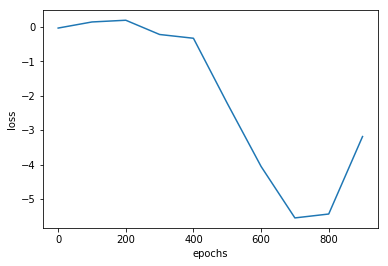

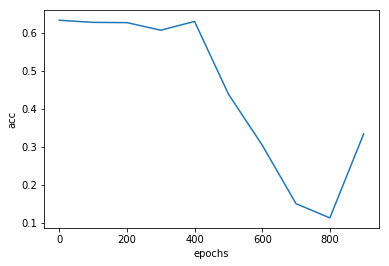

In [20]:
def speaker_w_ideal_listener_train(speaker, vocab, opt, n_epochs, n_batch, verbose = False):
    #training parameters

    g = graph(epoch = [], loss = [], acc = [])

    original_meanings = list(vocab.keys())
    original_meanings_1h = one_hot(t.LongTensor(original_meanings).unsqueeze(-1), N_MEANINGS)
    shuffled_meanings = list(original_meanings)

    for epoch in range(n_epochs):
        random.shuffle(shuffled_meanings)

        batch_meanings = shuffled_meanings[:n_batch]
        batch_meanings_1h = one_hot(t.LongTensor(batch_meanings).unsqueeze(-1), N_MEANINGS)
        loss = speaker_w_ideal_listener_step(speaker,
                                             batch_meanings_1h,
                                             opt)

        if(epoch % 100 == 0):
            acc = eval_speaker_ideal_listener(original_meanings_1h, speaker, n_trials = 100)
            if(verbose):
                g.epoch.append(epoch)
                g.loss.append(loss)
                g.acc.append(acc)
                print(f"epoch: {epoch}, loss: {loss}, acc: {acc}")


    print(f"After {epoch+1} epochs, acc: {acc}")
    if(verbose):
        plt.plot(g.epoch,g.loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

        plt.plot(g.epoch,g.acc)
        plt.xlabel('epochs')
        plt.ylabel('acc')
        plt.show()

if False:
    #initialize agent and vocab
    speaker_agent = Speaker(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
    params = list(speaker_agent.parameters())
    opt = torch.optim.Adam(params, lr = 7e-3, weight_decay = 0)
    vocab = generate_vocab()


    speaker_w_ideal_listener_train(speaker_agent, vocab, opt, n_epochs = 1000, n_batch = N_MEANINGS, verbose = True)


In [21]:
#Sample utterances from the speaker
m_1h = one_hot(t.LongTensor(list(vocab.keys())).unsqueeze(-1), N_MEANINGS)
sample_speaker(m_1h,speaker_agent)
print(eval_speaker_ideal_listener(m_1h, speaker_agent, n_trials = 100))

Meaning: 0, Speaker: tensor([8], device='cuda:0')
Meaning: 1, Speaker: tensor([5], device='cuda:0')
Meaning: 2, Speaker: tensor([12], device='cuda:0')
Meaning: 3, Speaker: tensor([5], device='cuda:0')
Meaning: 4, Speaker: tensor([8], device='cuda:0')
Meaning: 5, Speaker: tensor([11], device='cuda:0')
Meaning: 6, Speaker: tensor([12], device='cuda:0')
Meaning: 7, Speaker: tensor([15], device='cuda:0')
Meaning: 8, Speaker: tensor([5], device='cuda:0')
Meaning: 9, Speaker: tensor([15], device='cuda:0')
Meaning: 10, Speaker: tensor([3], device='cuda:0')
Meaning: 11, Speaker: tensor([8], device='cuda:0')
Meaning: 12, Speaker: tensor([11], device='cuda:0')
Meaning: 13, Speaker: tensor([5], device='cuda:0')
Meaning: 14, Speaker: tensor([8], device='cuda:0')
Meaning: 15, Speaker: tensor([8], device='cuda:0')
0.47375


### RL Joint Train

In [0]:
def rl_joint_train(speaker, listener, vocab, opt, n_epochs, n_batch, verbose = False, verbose_rate = 250):
    #training parameters

    g = graph(epoch = [], loss = [], acc = [])

    original_meanings = list(vocab.keys())
    shuffled_meanings = list(original_meanings)

    for epoch in range(n_epochs):
        random.shuffle(shuffled_meanings)
    
        batch_meanings = shuffled_meanings[:n_batch]
        batch_meanings_1h = one_hot(t.LongTensor(batch_meanings*10).unsqueeze(-1), N_MEANINGS)
        loss = rl_step(speaker_agent, listener_agent,  
                       batch_meanings_1h,
                       opt)

        if(epoch % verbose_rate == 0):
            acc = eval_joint_acc(batch_meanings_1h, speaker, listener, n_trials = 100).mean()

            g.epoch.append(epoch)
            g.loss.append(loss)
            g.acc.append(acc)
            if(verbose):
                print(f"epoch: {epoch}, loss: {loss}, acc: {acc}")

    return g

if False:
    #initialize agent and vocab
    speaker_agent = Speaker(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
    listener_agent = Listener(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
    params = list(speaker_agent.parameters()) + list(listener_agent.parameters())
    opt = torch.optim.Adam(params, lr = 7e-3, weight_decay = 1e-4)
    vocab = generate_vocab()


    g = rl_joint_train(speaker_agent, listener_agent, vocab, opt, n_epochs = 10000, n_batch = N_MEANINGS, verbose = True)
    
    plt.subplot(2,1,1)
    plt.plot(g.epoch,g.loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.subplot(2,1,2)
    plt.plot(g.epoch,g.acc)
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.show()


## Test

Trial #0
Trial #1
Trial #2


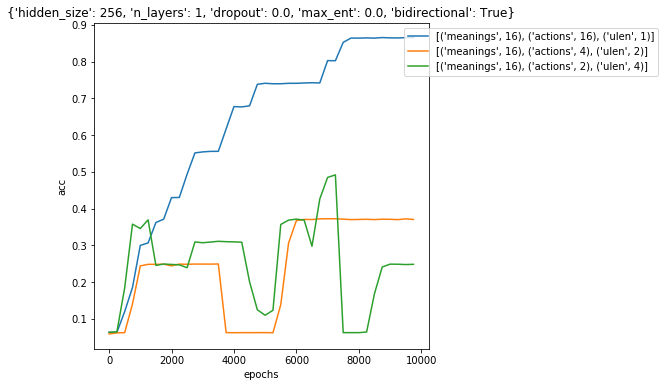

Trial #0
Trial #1
Trial #2


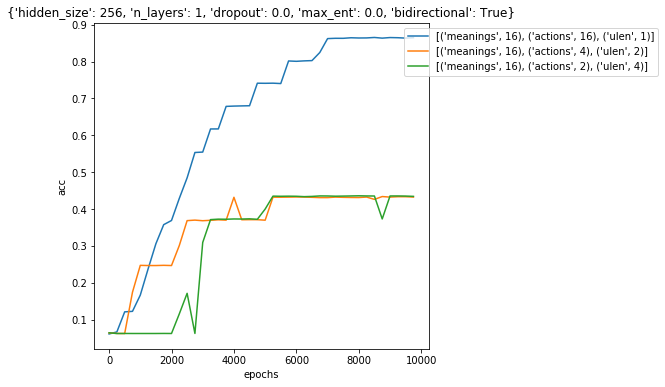

Trial #0
Trial #1
Trial #2


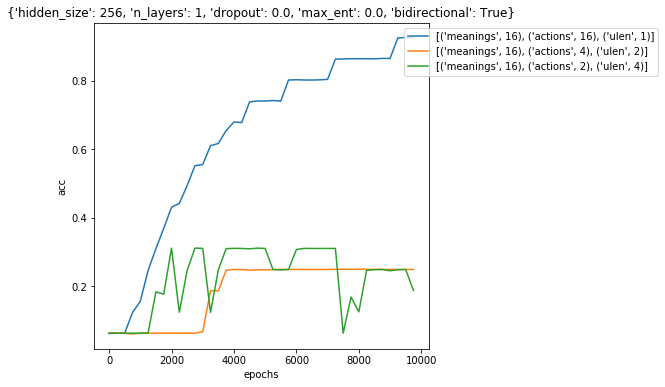

In [26]:
param_list1 = [(16,16,1),(16,4,2),(16,2,4)]
param_list2 = [(64,64,1),(64,8,2),(64,4,3),(64,2,6)]

exps = {i:param_list1[i] for i in range(3)}
graphs = {}




for _ in range(3):
    print(f"Trial #{i}")
    vocab = generate_vocab()
    for i in exps:
        print(f"Training: {exps[i]}")
        N_MEANINGS, N_ACTIONS, U_LEN =  exps[i]
        speaker_agent = Speaker(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
        listener_agent = Listener(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
        params = list(speaker_agent.parameters()) + list(listener_agent.parameters())
        opt = torch.optim.Adam(params, lr = 7e-3, weight_decay = 1e-4)
        graphs[i+_] = rl_joint_train(speaker_agent, listener_agent, vocab, opt, n_epochs = 10000, n_batch = N_MEANINGS, verbose = False)
    
    FIG_SIZE = (6,6)
    plt.figure(figsize = FIG_SIZE)
    for i in range(3):
        plt.plot(graphs[i+_].epoch, graphs[i+_].acc, label = str(list(zip(["meanings","actions","ulen"],exps[i]))))

    plt.legend(loc = 1, bbox_to_anchor=(1.7,1.))
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title(str(HYPERPARAMETERS))
    plt.show()


## Misc.

In [0]:
# FIG_SIZE = (15,15)

# # plt.subplots_adjust(wspace=20., hspace=20.)
# plt.figure(figsize = FIG_SIZE)
# for i in range(3):
#     plt.subplot(3,2,(i*2 + 1))
#     plt.plot(graphs[i].epoch,graphs[i].loss)
#     plt.xlabel('epochs')
#     plt.ylabel('loss')
#     plt.title(list(zip(["meanings","actions","ulen"],exps[i])))
    
#     plt.subplot(3,2,(i*2 + 2))
#     plt.plot(graphs[i].epoch,graphs[i].acc)
#     plt.xlabel('epochs')
#     plt.ylabel('acc')
#     plt.title(list(zip(["meanings","actions","ulen"],exps[i])))
# plt.show()

FIG_SIZE = (8,8)
plt.figure(figsize = FIG_SIZE)
print(graphs[0])
for _ in range(3):
    for i in range(3):
        print(i+_)
        plt.plot(graphs[i+_].epoch, graphs[i].acc, label = str(list(zip(["meanings","actions","ulen"],exps[i]))))

    plt.legend(loc = 1, bbox_to_anchor=(1.7,1.))
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title(str(HYPERPARAMETERS))
    plt.show()

In [0]:
#initialize agent and vocab
vocab = generate_vocab()

speaker_agent = Speaker(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
params = list(speaker_agent.parameters())

schedule = [(100,1e-1),
            (200,1e-2),
            (300,1e-3),
            (1000,1e-4)]
for _ in range(2):
    for i in range(len(schedule)):
        scheduled_n_epochs = schedule[i][0]
        scheduled_lr = schedule[i][1]
        opt = torch.optim.Adam(params, lr = scheduled_lr, weight_decay = 0.0)
        speaker_train_on_vocab(speaker_agent, vocab, opt, n_epochs = scheduled_n_epochs, n_batch = N_MEANINGS, verbose = False)

In [0]:
# speaker_agent = Speaker(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
listener_agent = Listener(meaning_size = N_MEANINGS, action_size = N_ACTIONS, max_u_len = U_LEN, **HYPERPARAMETERS).to(device)
params = list(listener_agent.parameters())
opt = torch.optim.Adam(params, lr = 1e-2, weight_decay = 0.0)
rl_joint_train(speaker_agent, listener_agent, vocab, opt, n_epochs = 10000, n_batch = N_MEANINGS, verbose = True)


In [0]:
!pip freeze